# <span style="color:#F72585"><center>Tutorial TensorFlow Probability (TFP)</center></span>


## <span style="color:#4361EE">Introducción</span>


Se introducen los elementos esenciales del uso de TFP. En este cuaderno usamos el ejemplo de 8 escuelas (eight schools) que utilizamos en el primer ejemplo de TFP en este curso. Este cuaderno es una adaptación de [ocho escuelas](https://www.tensorflow.org/probability/examples/Eight_Schools)

## <span style="color:#4361EE">El modelo estadístico para este tutorial</span>


Supongamos que tenemos observaciones $[y_n |x_n], n=1,\ldots,N$, y asumamos el modelo Bayesiano. 

**Modelo con efectos aleatorios**

- Estima los hiperparámetros $\mu$ and $\tau$
- Predice los efectos aleatorios $\eta_i$


$$
\begin{align*}
y_i &\sim \mathcal{N}(\theta_i,\sigma_i^2), \text{ known } \sigma_i^2\\
\theta_i & = \mu + \tau \times \eta_i \\
\eta_i &\sim \mathcal{N}(0, 1)\\
\mu &\sim \mathcal{N}(0,10)\\
\log\tau &\sim \mathcal{N}(5,1)
\end{align*}
$$


### <span style="color:#4CC9F0">Los datos</span>


Los datos corresponden a la estimación (estandarizada) de un puntaje realizada en las ocho escuelas observadas. Este ejemplo es tratado en {cite}`gelman1995bayesian`


```{table}
|School |Estim. Treatment Effect | Estim. Stand. Error |
|---|---|---|
|A |28| 15|
|B |8 |10|
|C| -3| 16|
|D| 7| 11|
|E| -1 |9|
|F| 1| 11|
|G |18| 10|
|H| 12| 18|
```

In [2]:
# Importamos las librerías requeridas
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import warnings

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')


In [3]:
# Los datos
J = 8 #Número de escuelas
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.], dtype=np.float32) #Estimaciones de los efectos del tratamiento
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.], dtype=np.float32) #Estimacion de la desviacion de los efectos del tratamiento
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])

schools_dat = {'J': J,
               'y': y,
               'sigma': sigma}
schools_dat 

{'J': 8,
 'y': array([28.,  8., -3.,  7., -1.,  1., 18., 12.], dtype=float32),
 'sigma': array([15., 10., 16., 11.,  9., 11., 10., 18.], dtype=float32)}

## <span style="color:#4361EE">Implementación del modelo estadístico en TFP</span>


In [4]:
model = tfd.JointDistributionSequential([
  tfd.Normal(loc=0., scale=10., name="efecto_promedio"),  # `mu` 
  tfd.Normal(loc=5., scale=1., name="desviacion_efecto"),  # `Tau``
  tfd.Independent(tfd.Normal(loc=tf.zeros(J),
                             scale=tf.ones(J),
                             name="efectos_estandar_colegios"),  # eta_i. Recordemos que eta_i es un vector
                  reinterpreted_batch_ndims=1),
  lambda efectos_estandar_colegios, desviacion_efecto, efecto_promedio: (
      tfd.Independent(tfd.Normal(loc=(efecto_promedio[..., tf.newaxis] +
                                      tf.exp(desviacion_efecto[..., tf.newaxis]) * 
                                      efectos_estandar_colegios),  # `theta` 
                                 scale=sigma),
                      name="efectos_tratamiento",  # `y` 
                      reinterpreted_batch_ndims=1))
])

def target_log_prob_fn(efecto_promedio, desviacion_efecto, efectos_estandar_colegios):
  """Densidad objetivo no normalizada como función de estados."""
  return model.log_prob((
      efecto_promedio, desviacion_efecto, efectos_estandar_colegios, sigma))


En este código los prámetros que serán muestreados son $\mu$ (*mu*), $\tau$ (*tau*), que es una desviación estándar y los $\eta_i$ (*eta*) que son los efectos aleatorios en el modelo. Las medias $\theta_i$ de las escuelas son calculados. Es decir, son funcionales de los parámetros.

## <span style="color:#4361EE">Compilación del modelo</span>


- `tf.function`: Compila una función como un grafo, esto ayudará a obtener un mejor rendimiento
- `XLA`: Es un compilador que mejora la velocidad y el uso de memoria en modelos de TensorFlow sin hacer cambios considerables en el código fuente
- `tfp.mcmc.HamiltonianMonteCarlo`: Esta clase implementa un paso aleatorio HMC desde un estado de información.

In [5]:
num_results = 5000
num_burnin_steps = 3000

# Mejorar el rendimiento rastreando el muestreador con `tf.function`
# y compilarlo usando XLA.
# autograph transforma un subconjunto de código de Python a TensorFlow
#jit_compile compila la función usando XLA
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
    # Muestreador que usa cadenas de Markov
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      # Representación de nuestra previa
      current_state=[
          tf.zeros([], name='init_efecto_promedio'),
          tf.zeros([], name='init_desviacion_efecto'),
          tf.ones([J], name='init_efectos_estandar_colegios'),
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          # Devuelve la log-densidad de nuestra previa
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.4,
          num_leapfrog_steps=3))

states, kernel_results = do_sampling()

efecto_promedio, desviacion_efecto, efectos_estandar_colegios = states

Una vez el modelo es compilado, se pueden generar muestras cuando se desee. Por ejemplo:

In [6]:
school_effects_samples = (
    efecto_promedio[:, np.newaxis] +
    np.exp(desviacion_efecto)[:, np.newaxis] * efectos_estandar_colegios)

num_accepted = np.sum(kernel_results.is_accepted)
print('Acceptance rate: {}'.format(num_accepted / num_results))


Acceptance rate: 0.6626


## <span style="color:#4361EE">Inferencia Bayesiana</span>

### <span style="color:#4CC9F0">Distribución Posterior</span>


Podemos graficar la densidad de la distribución posterior $x|y$

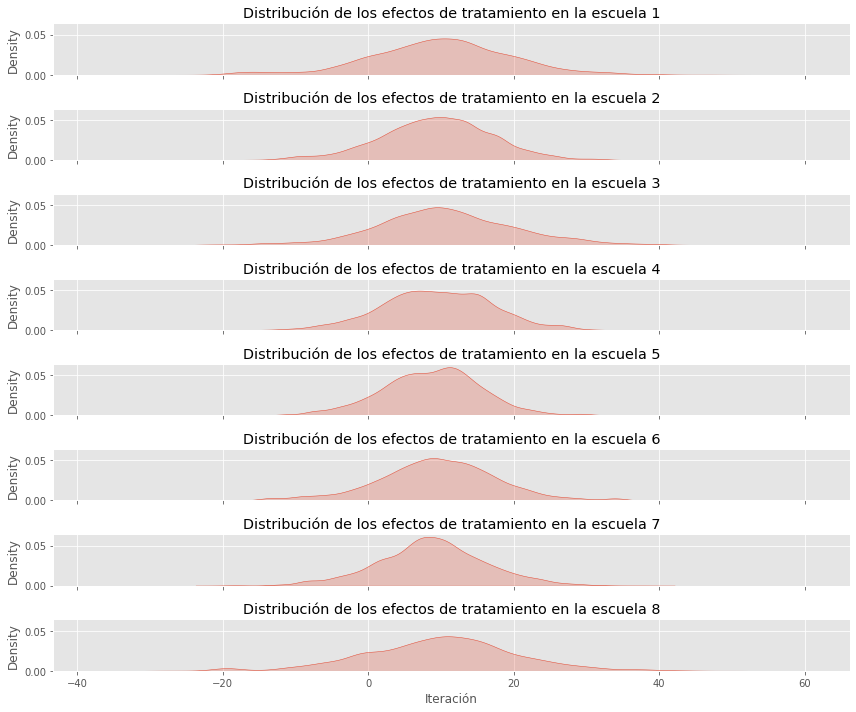

In [7]:
fig, axes = plt.subplots(8, 1, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(J):
  sns.kdeplot(school_effects_samples[:,i].numpy(), ax=axes[i], shade=True)
  axes[i].title.set_text("Distribución de los efectos de tratamiento en la escuela {}".format(i+1))
axes[J - 1].set_xlabel("Iteración")
fig.tight_layout()
plt.show()



### <span style="color:#4CC9F0">Estadísticas Descriptivas</span>


In [8]:
print("E[efecto_promedio] = {}".format(np.mean(efecto_promedio)))
print("E[desviacion_efecto] = {}".format(np.mean(desviacion_efecto)))
print("E[efectos_estandar_colegios] =",np.mean(np.mean(efectos_estandar_colegios[:, ])))

print("E[school_effects] =")
print(np.mean(school_effects_samples[:, ], axis=0))

E[efecto_promedio] = 6.445228099822998
E[desviacion_efecto] = 2.320098400115967
E[efectos_estandar_colegios] = 0.18683586
E[school_effects] =
[ 9.886898  9.313621 10.659475  9.479875  8.715329  9.5378    8.700358
  9.848931]


### <span style="color:#4CC9F0">Intervalos de credibilidad</span>


In [9]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(J)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(J)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(J)
])


In [37]:
for i in range (J):
    print("Intervalo de credibilidad para la escuela",i+1,"\n({},{})".format(school_effects_low[i],school_effects_hi[i]))
    print("Media posterior para la escuela",i+1,"={}".format(school_effects_med[i]))

Intervalo de credibilidad para la escuela 1 
(-13.078752136230467,29.63158092498774)
Media posterior para la escuela 1 =10.050765037536621
Intervalo de credibilidad para la escuela 2 
(-7.039254188537598,24.164723682403558)
Media posterior para la escuela 2 =9.581928253173828
Intervalo de credibilidad para la escuela 3 
(-9.633618307113647,30.853418684005707)
Media posterior para la escuela 3 =10.054023265838623
Intervalo de credibilidad para la escuela 4 
(-6.017398118972777,25.522802352905273)
Media posterior para la escuela 4 =9.413681983947754
Intervalo de credibilidad para la escuela 5 
(-5.725653219223022,22.330745697021484)
Media posterior para la escuela 5 =8.999722003936768
Intervalo de credibilidad para la escuela 6 
(-9.232978820800781,26.415463685989355)
Media posterior para la escuela 6 =9.542043209075928
Intervalo de credibilidad para la escuela 7 
(-7.369322252273559,23.754505109786987)
Media posterior para la escuela 7 =8.636335372924805
Intervalo de credibilidad para l

## <span style="color:#4361EE"> Referencias </span>


```{bibliography}
:filter: docname in docnames
```